<a href="https://colab.research.google.com/github/Maaz868/SurvAillant/blob/main/Testing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf

In [47]:
# Load the dataset from CSV file
df = pd.read_csv('outputDos.csv')

# Select features of interest
selected_features = ['protocol', 'timestamp', 'payload_size', 'src_ip']

# Extract the features
selected_data = df[selected_features]

# Convert 'timestamp' to a numeric value (e.g., seconds since epoch)
selected_data['timestamp'] = pd.to_datetime(selected_data['timestamp']).astype(int) / 10**9  # Convert to seconds

# Convert categorical features to numerical using one-hot encoding
selected_data = pd.get_dummies(selected_data, columns=['protocol'])

# Separate non-numeric columns
non_numeric_cols = ['src_ip']
numeric_data = selected_data.drop(non_numeric_cols, axis=1)

# Standardize the numeric features
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)
numeric_data_scaled_df = pd.DataFrame(numeric_data_scaled, columns=numeric_data.columns)  # Convert to DataFrame

# Combine scaled numeric features with non-numeric features
selected_data_scaled = pd.concat([numeric_data_scaled_df, selected_data[non_numeric_cols]], axis=1)

# Split the dataset into training, validation, and test sets
X_train, X_temp = train_test_split(selected_data_scaled, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)


<ipython-input-47-e7b68a0f383e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['timestamp'] = pd.to_datetime(selected_data['timestamp']).astype(int) / 10**9  # Convert to seconds


In [48]:
# Convert DataFrames to NumPy arrays
X_train_numeric = X_train.drop(['src_ip'], axis=1).to_numpy()
X_val_numeric = X_val.drop(['src_ip'], axis=1).to_numpy()
X_test_numeric = X_test.drop(['src_ip'], axis=1).to_numpy()

# Convert NumPy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train_numeric, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val_numeric, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_numeric, dtype=tf.float32)

# Build an autoencoder model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_tensor.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train_tensor.shape[1], activation='linear')
])

In [58]:
model.compile(optimizer='adam', loss='mean_squared_error')

827/827 [==============================] - 3s 4ms/step - loss: 9.9976e-05


KeyError: ignored

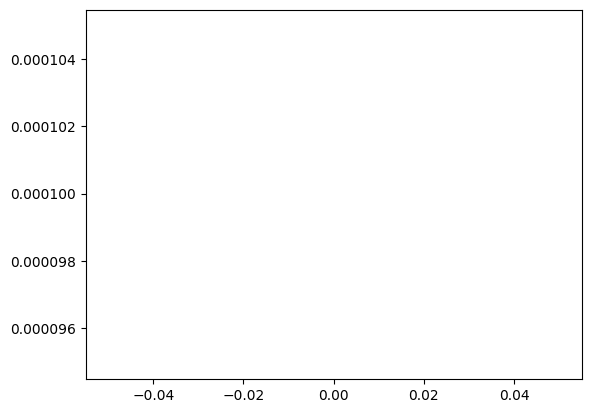

In [60]:
# Train the model
# history = model.fit(X_train_tensor, X_train_tensor, epochs=50, batch_size=32)
history = model.fit(X_train_tensor, X_train_tensor, epochs=50, batch_size=32, validation_data=(X_val_tensor, X_val_tensor))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [51]:
# Inference on the test set
X_test_pred = model.predict(X_test_tensor)

276/276 [==============================] - 1s 2ms/step


In [52]:
# Check the shapes of X_test and X_test_pred
# if X_test.shape[1] != X_test_pred.shape[1]:
#     raise ValueError("Mismatch in the number of features between X_test and X_test_pred")
if X_test.drop(['src_ip'], axis=1).shape[1] != X_test_pred.shape[1]:
    raise ValueError("Mismatch in the number of features between X_test and X_test_pred")

# Evaluate on test set
mse = ((X_test_numeric - X_test_pred) ** 2).mean(axis=1)  # Mean Squared Error for each sample
threshold = mse.mean() + 2 * mse.std()  # Set a threshold for anomaly detection


In [54]:
# Reconstruction accuracy for training, validation, and testing sets
train_acc = (1 - history.history['loss'][-1]) * 100
val_acc = (1 - history.history['val_loss'][-1]) * 100
test_acc = (np.sum(mse <= threshold) / len(mse)) * 100

# Display accuracies
print(f"Training Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")

Training Accuracy: 99.96%
Validation Accuracy: 100.00%
Testing Accuracy: 99.70%
